In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_5_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import t
import statsmodels.api as sm

Caricamento file pickle

In [2]:
# Caricamento di models e models_atmos
with open('models_atmos_new.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)
    list_4_clusters_new = dill.load(file)
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

Bias della multi model mean

In [3]:
#Calcolo della multi model mean del bias di vento zonale a 850hPa
sum_multi_model = 0
for name in models_atmos.keys():
    sum_multi_model = sum_multi_model + models_atmos[name]['atmos North Atlantic bias DJF']
#Calcolo della multi model mean
bias_multi_model_mean = sum_multi_model / len(models_atmos)

Inizio con linear regression tra bias di vento zonale e x (risoluzione atmosferica,...): ricerco mappa di coefficienti angolari m per ogni punto griglia

Creo la matrice Y con dimensioni = (35,30x78)
- Creo la matrice Y di numero di righe = # modelli e numero di colonne pari al numero di punti griglia.
- Se l'elemento ij-esimo è nan elimino tutta la colonna 
- All'interno della matrice ci sono i valori di bias di vento zonale a 850hPa

In [4]:
n_rows = len(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lat.values) # prendo un modello generico e calcolo il numero di righe, pari al numero di grid cell sulla latitudine
n_cols = len(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'].lon.values) #il numero di colonne è pari al numero di grid cell sulla longitudine
n_elements = n_rows * n_cols
n_models = len(models_atmos) # numero di modelli

In [5]:
np_array_models_2d = np.zeros((n_rows,n_cols)) #inizializzazione array 2-dim, che ha sulle colonne la longitudine e sulle righe la latitudine e andrò a mettere i valori dei bias di temperatura della stagione MAM
np_array_models_1d = np.zeros(n_elements) #inizializzazione array 1-dim, creato con righe di np_array_models_2d messe una accanto all'altra
Y_init = np.zeros((n_models,n_elements)) #inizializzazione matrice con righe pari al numero di modelli e per ogni riga vado a mettere 
i = 0 #inizializzazione indice righe feature_matrix_init
Y_init.shape

(35, 2040)

In [6]:
for name in models_atmos.keys(): #models_list è una lista contenente il nome di tutti i modelli che sto utilizzando. Quindi ciclo sul numero dei modelli
    #Creo array
    np_array_models_2d = models_atmos[name]['atmos North Atlantic bias DJF'].values #estraggo i valori da bias MAM e li metto in un array 2d, dove sulle righe c'è la latitudine e sulle colonne la longitudine
    np_array_models_1d = np_array_models_2d.flatten() #array 1d con numero di elementi pari a lat x lon (messe una accanto all'altra le righe dell'array 2d precedente)
    #Creo feature matrix
    Y_init[i,:] = np_array_models_1d #ogni riga di feature_matrix_init è pari a np_array_models_1d
    i = i + 1 #aggiorno indice i

In [7]:
Y_init.shape

(35, 2040)

Elimino le colonne contenenti 'nan'

In [8]:
#Elimino le colonne che contengono almeno un nan e creo la feature_matrix
Y = np.empty((n_models,0)) #inizializzo la nuova feature matrix, cioè la matrice senza nan
number_nan = 0 #inizializzo il numero dei number nan
arr = np.zeros(n_models) #inizializzo array di dimensione pari al numero di modelli
cell_grid_nan = [] #lista vuota che contiene il numero delle celle della griglia che hanno elementi nan e che quindi vengono eliminate per il calcolo di feature_matrix

for j in range(n_elements): #ciclo sulle colonne di feature_matrix_init   
    if np.isnan(Y_init[:,j]).any(): #se c'è almeno un elemento nan all'interno della colonna
        cell_grid_nan.append(j) #costruisco la cella con il numero delle colonne che contengono elementi nan
        number_nan = number_nan + 1 #aggiorno il numero di colonne che hanno almeno un elemento nan
    else: #se la colonna non contiene nan
        arr = Y_init[:,j]
        Y = np.column_stack((Y,arr)) #aggiungo la colonna di feature_matrix_init senza nan alla matrice feature_matrix
    

In [9]:
print(cell_grid_nan)

[0, 1, 2, 68, 69, 136, 137, 476, 477, 544, 545, 612, 613, 680, 681, 748, 749, 1457, 1458, 1524, 1525, 1526, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012]


In [10]:
len(cell_grid_nan)

140

In [11]:
Y.shape

(35, 1900)

Funzione per array 1d X generico, di dimensioni 35x1

In [12]:
#Creo un vettore x di dimensioni pari al numero dei modelli, in cui vado ad inserire i valori di risoluzione atmosferica(opp. ris. oceanica, o la posizione della gulf stream, o RMSE oceanico) per ogni modello
def compute_array_X(n_models,name_dict): #n_models = models/models_atmos; name_dict = ris. atm/oceanica,... Ad es. è'atmos model resolution' in models_atmos[name]['atmos model resolution']
    X = np.zeros(len(n_models)) # inizializzo l'array X, di dimensioni pari al numero di modelli
    n = 0 #inizializzo indice array X
    for name in n_models.keys():
        X[n] = n_models[name][name_dict]
        n = n + 1
    return X

Funzione per coefficiente angolare m e m_reshape per poterlo plottare

In [13]:
def compute_angular_coefficient(Y, X, n_rows, n_cols, cell_grid_nan, value_alpha):
    #Inizializzazione del coefficiente angolare m, del p-valore e di R^2
    m = np.zeros((Y.shape[1]))
    p_value = np.zeros((Y.shape[1]))
    r_2 = np.zeros((Y.shape[1]))

    n = len(X)  #35
    X = X.reshape(-1, 1) #reshape di X per farlo diventare un array 35x1

    #Regressione lineare
    for j in range(Y.shape[1]):  # Iterate over all grid points, i.e., columns of the Y matrix
        #fit del modello lineare
        model = LinearRegression()
        model.fit(X, Y[:, j])
        #Calcolo del coefficiente angolare
        m[j] = model.coef_[0] #[0] perché è il coefficiente della prima feature (in questo caso abbiamo un'unica feature che è X)

        #Calcolo di R^2
        r_2[j] = model.score(X, Y[:, j])

        # Calculate standard error of the slope (SE)
        y_pred = model.predict(X)
        residuals = Y[:, j] - y_pred
        residual_sum_of_squares = np.sum(residuals ** 2)
        s_err = np.sqrt(residual_sum_of_squares / (n - 2))

        # Standard error of the slope
        X_mean = np.mean(X)
        std_err_slope = s_err / np.sqrt(np.sum((X - X_mean) ** 2))

        # Calculate t-statistic for the slope
        t_stat = m[j] / std_err_slope

        # Calculate two-tailed p-value from t-statistic
        p_value[j] = 2 * (1 - t.cdf(abs(t_stat), df=n - 2))  # Two-tailed test

    # Reshape m, r-2, p-value into dimensions n_rows x n_cols, including NaN
    k = 0  # Index for the cell_grid_nan vector
    l = 0  # Index for the m vector
    p = 0
    m_reshape = np.zeros((n_rows, n_cols))  # Reshape m to lat x lon dimensions, including NaNs removed initially
    r_2_reshape = np.zeros((n_rows, n_cols))
    p_value_reshape = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            if k < len(cell_grid_nan) and p == cell_grid_nan[k]:  # p-th element is NaN, cell_grid_nan starts from 0
                m_reshape[i, j] = np.nan
                r_2_reshape[i,j] = np.nan
                p_value_reshape[i] = np.nan
                k = k + 1
            else:
                m_reshape[i, j] = m[l]
                r_2_reshape[i,j] = r_2[l]
                p_value_reshape[i] = p_value[l]
                l = l + 1
            p = p + 1

    #Significatività del p-value
    alpha = value_alpha
    significant = p_value_reshape <= alpha #matrice di True e False
    #Creo una matrice di 0 e 1: 1 dove si ha significatività statistica, 0 dove non si ha significatività statistica
    significant = significant.astype(int)

    #Inserisco tutte le variabili in una lista epr facilitarne la lettura
    result = [m, m_reshape, r_2, r_2_reshape, p_value, p_value_reshape, significant]
    return result

In [14]:
!pip install statsmodels

In [15]:
def compute_angular_coefficient(Y, X, n_rows, n_cols, cell_grid_nan, value_alpha):
    # Inizializzazione del coefficiente angolare m, del p-valore e di R^2
    m = np.zeros((Y.shape[1]))
    p_value = np.zeros((Y.shape[1]))
    r_2 = np.zeros((Y.shape[1]))

    n = len(X)  # 35
    X = sm.add_constant(X)  # Add constant (intercept) to the model

    # Regressione lineare
    for j in range(Y.shape[1]):  # Iterate over all grid points, i.e., columns of the Y matrix
        # Fit del modello lineare usando statsmodels
        model = sm.OLS(Y[:, j], X)
        results = model.fit()

        # Coefficiente angolare (slope)
        m[j] = results.params[1]  # [1] because the first parameter is the intercept

        # Calcolo di R^2
        r_2[j] = results.rsquared

        # p-value del coefficiente angolare
        p_value[j] = results.pvalues[1]  # [1] because the first p-value corresponds to the slope

    # Reshape m, r-2, p-value into dimensions n_rows x n_cols, including NaN
    k = 0  # Index for the cell_grid_nan vector
    l = 0  # Index for the m vector
    p = 0
    m_reshape = np.zeros((n_rows, n_cols))  # Reshape m to lat x lon dimensions, including NaNs removed initially
    r_2_reshape = np.zeros((n_rows, n_cols))
    p_value_reshape = np.zeros((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            if k < len(cell_grid_nan) and p == cell_grid_nan[k]:  # p-th element is NaN, cell_grid_nan starts from 0
                m_reshape[i, j] = np.nan
                r_2_reshape[i, j] = np.nan
                p_value_reshape[i, j] = np.nan
                k = k + 1
            else:
                m_reshape[i, j] = m[l]
                r_2_reshape[i, j] = r_2[l]
                p_value_reshape[i, j] = p_value[l]
                l = l + 1
            p = p + 1

    # Significatività del p-value
    alpha = value_alpha
    significant = p_value_reshape <= alpha  # Matrice di True e False
    # Creo una matrice di 0 e 1: 1 dove si ha significatività statistica, 0 dove non si ha significatività statistica
    significant = significant.astype(int)

    # Inserisco tutte le variabili in una lista per facilitarne la lettura
    result = [m, m_reshape, r_2, r_2_reshape, p_value, p_value_reshape, significant]
    return result


Funzione per il plot di m_reshape con puntini laddove si ha significatività statistica

In [16]:
#Plot di m_reshape per vedere quandto valgono gli m nel box lonxlat considerato
def plot_m_reshape(box,m_reshape,significant,bias_multi_model_mean,title_plot,udm): #box = models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'], udm=unità di misura del coefficiente angolare
    fig,ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": ccrs.PlateCarree()})
    min_lon = box.lon.values.min()
    max_lon = box.lon.values.max()
    min_lat = box.lat.values.min()
    max_lat = box.lat.values.max()
    plot_mod = ax.imshow(m_reshape[::-1], aspect='auto',cmap='seismic',extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    coords = np.where(significant == 1) #matrice di significatività del p-valore, 1 indica dove si ha significatività statistica
    # Plot dei punti solo dove matrix10 è uguale a 1
    ax.plot(bias_multi_model_mean[0].lon[coords[1]], bias_multi_model_mean[0].lat[coords[0]], marker='o', color='black', markersize=2, linestyle='None', transform=ccrs.PlateCarree())
    contour_multi_model_mean = ax.contour(bias_multi_model_mean[0].lon, bias_multi_model_mean[0].lat, bias_multi_model_mean[0], colors='g') #[0] perché plev fissato
    ax.clabel(contour_multi_model_mean, fmt='%1.1f')
    ax.coastlines()
    ax.set_xticks(np.arange(min_lon,max_lon, 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat, 10), crs=ccrs.PlateCarree())
    ax.set_xlabel('longitude(deg)')
    ax.set_ylabel('latitude(deg)')
    # Creazione di un oggetto Line2D per la legenda
    green_line = Line2D([0], [0], color='green', lw=2, label='Multi model mean')  
    # Aggiungo la legenda al plot
    fig.legend(handles=[green_line],loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=1) 
    fig.colorbar(plot_mod, ax=ax).set_label(f'Angular Coefficient Value {udm}')
    fig.suptitle(title_plot, fontsize=16, y=1.02)
    fig.show()

In [17]:
#plot di R^2
def plot_r_2_reshape(box,r_2_reshape,title_plot):
    fig,ax = plt.subplots(figsize=(10,5), subplot_kw={"projection": ccrs.PlateCarree()})
    min_lon = box.lon.values.min()
    max_lon = box.lon.values.max()
    min_lat = box.lat.values.min()
    max_lat = box.lat.values.max()
    plot_mod = ax.imshow(r_2_reshape[::-1], aspect='auto',cmap='Greys',extent=[min_lon, max_lon, min_lat, max_lat], transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_xticks(np.arange(min_lon,max_lon, 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(min_lat,max_lat, 10), crs=ccrs.PlateCarree())
    ax.set_xlabel('longitude(deg)')
    ax.set_ylabel('latitude(deg)')
    fig.colorbar(plot_mod, ax=ax).set_label('R^2 Value')
    fig.suptitle(title_plot, fontsize=16, y=1.02)
    fig.show()

Linear regression con x = risoluzione atmosferica

In [18]:
X_atmos_res = compute_array_X(models_atmos,'atmos model resolution')

In [19]:
result_atmos_res = compute_angular_coefficient(Y,X_atmos_res,n_rows,n_cols,cell_grid_nan,0.05)

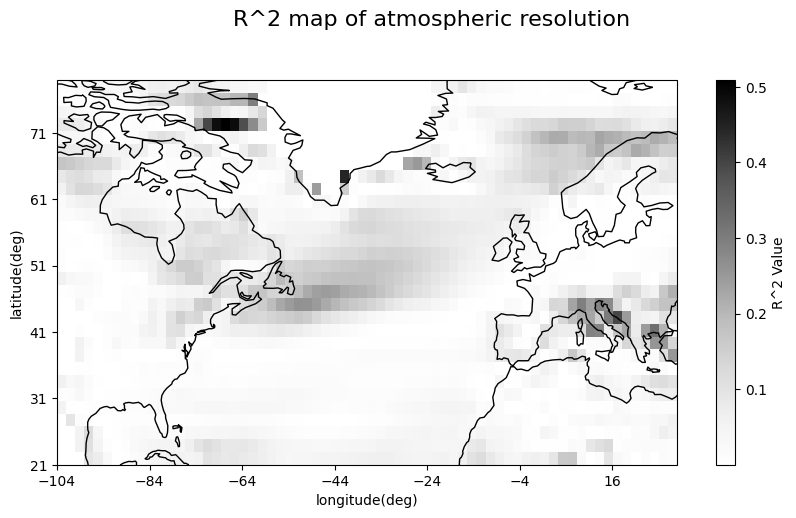

In [20]:
plot_r_2_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_atmos_res[3],'R^2 map of atmospheric resolution')

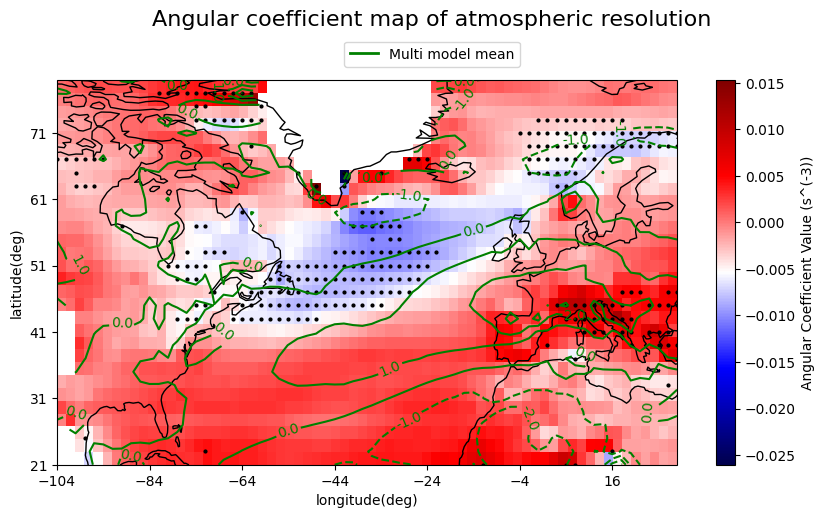

In [21]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_atmos_res[1],result_atmos_res[6],bias_multi_model_mean,'Angular coefficient map of atmospheric resolution','(s^(-3))')

Linear regression con x = risoluzione oceanica

In [22]:
X_ocean_res = compute_array_X(models,'model resolution')

In [23]:
result_ocean_res = compute_angular_coefficient(Y,X_ocean_res,n_rows,n_cols,cell_grid_nan,0.05)

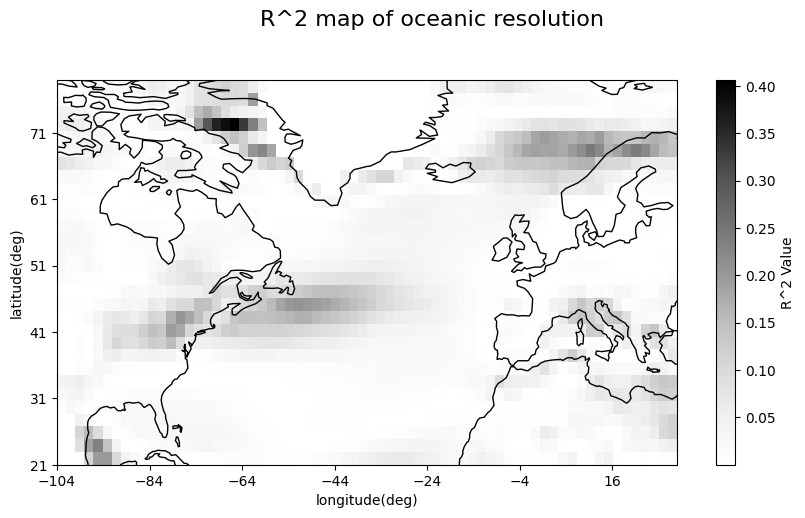

In [24]:
plot_r_2_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_ocean_res[3],'R^2 map of oceanic resolution')

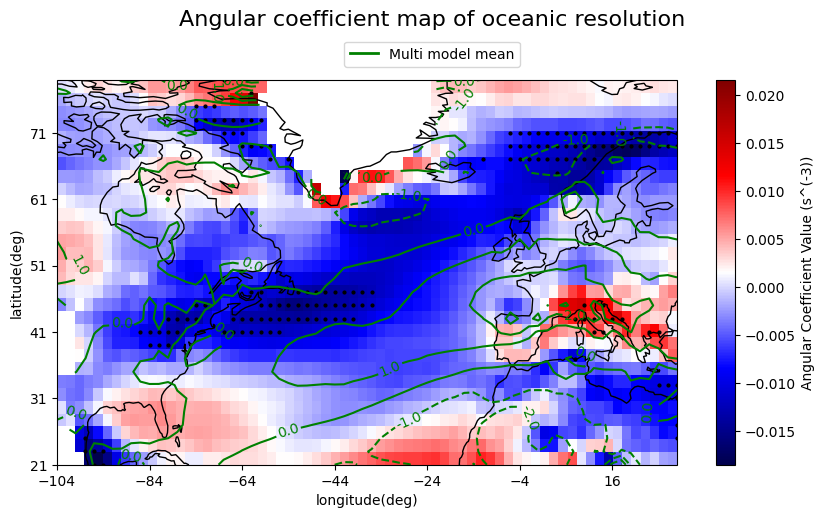

In [25]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_ocean_res[1],result_ocean_res[6],bias_multi_model_mean,'Angular coefficient map of oceanic resolution','(s^(-3))')

Linear regression con x = posizione gulf stream, cioè latitudine

In [26]:
X_gs_latitude = compute_array_X(models,'gs latitude')

In [27]:
result_gs_latitude = compute_angular_coefficient(Y,X_gs_latitude,n_rows,n_cols,cell_grid_nan,0.05)

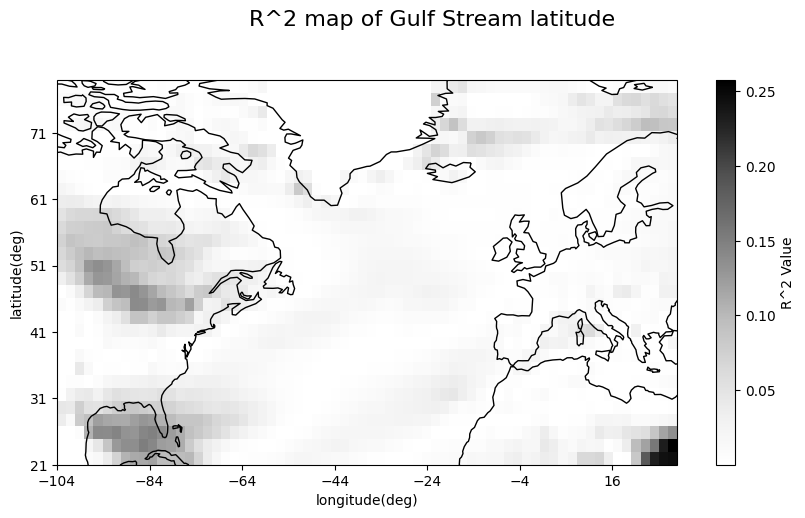

In [28]:
plot_r_2_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_gs_latitude[3],'R^2 map of Gulf Stream latitude')

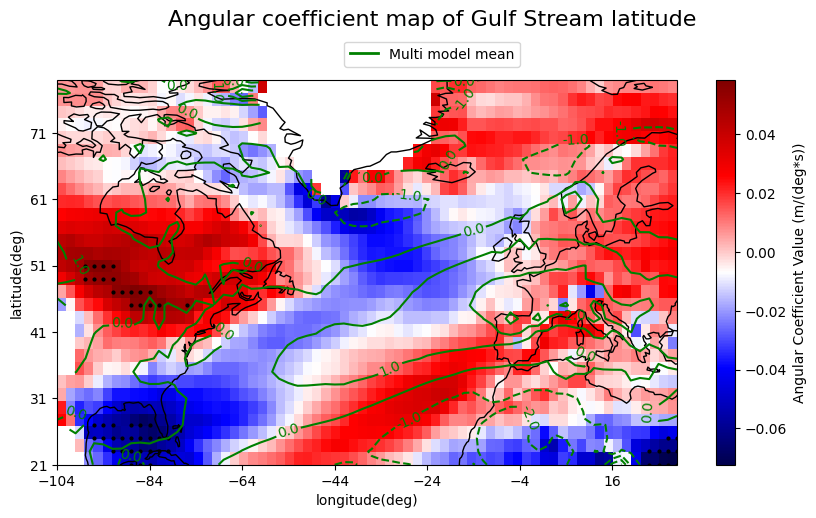

In [29]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_gs_latitude[1],result_gs_latitude[6],bias_multi_model_mean,'Angular coefficient map of Gulf Stream latitude','(m/(deg*s))')

Linear regression con x = intensità gulf stream

In [30]:
X_gs_intensity = compute_array_X(models,'gs intensity')

In [31]:
result_gs_intensity = compute_angular_coefficient(Y,X_gs_intensity,n_rows,n_cols,cell_grid_nan,0.05)

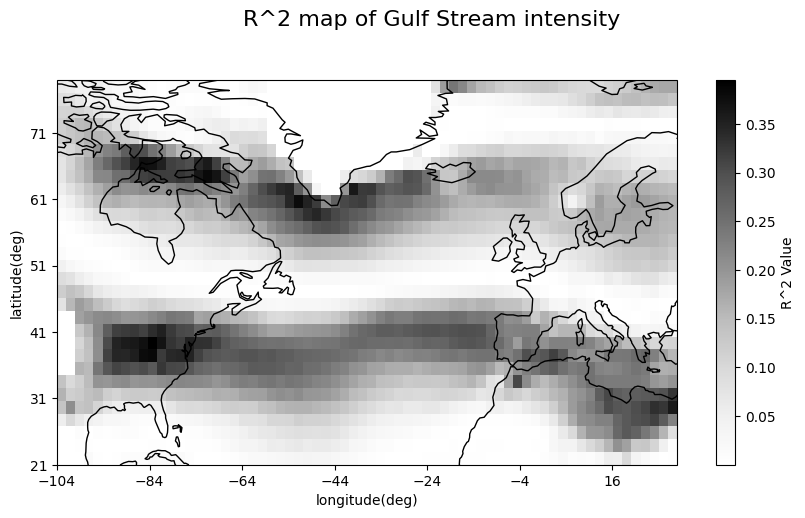

In [32]:
plot_r_2_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_gs_intensity[3],'R^2 map of Gulf Stream intensity')

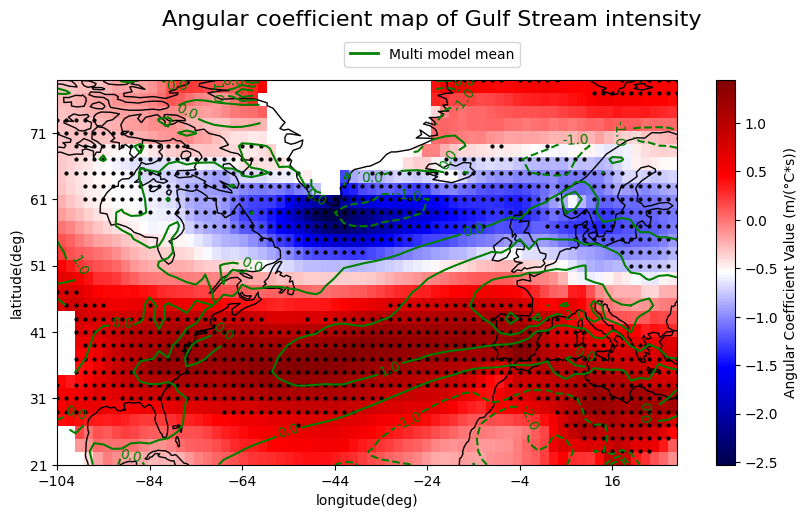

In [33]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_gs_intensity[1],result_gs_intensity[6],bias_multi_model_mean,'Angular coefficient map of Gulf Stream intensity','(m/(°C*s))')

Linear regression con x = RMSE oceanico

In [34]:
X_ocean_rmse = compute_array_X(models,'rms error')

In [35]:
result_ocean_rmse = compute_angular_coefficient(Y,X_ocean_rmse,n_rows,n_cols,cell_grid_nan,0.05)

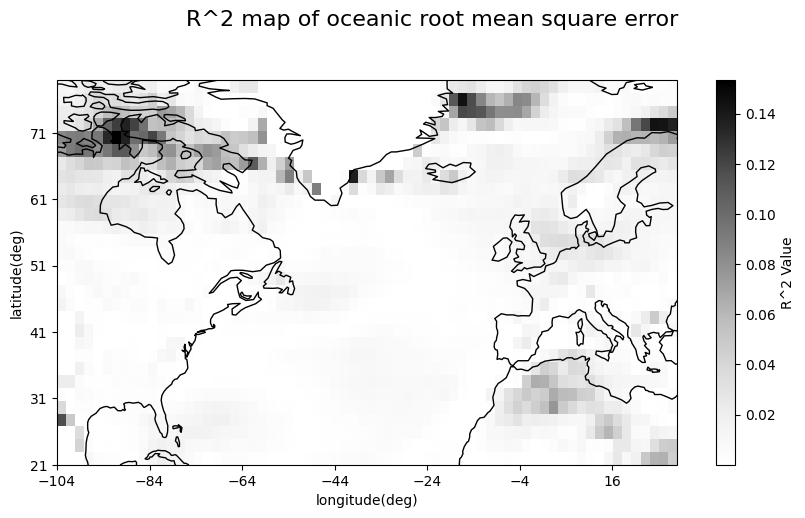

In [36]:
plot_r_2_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_ocean_rmse[3],'R^2 map of oceanic root mean square error')

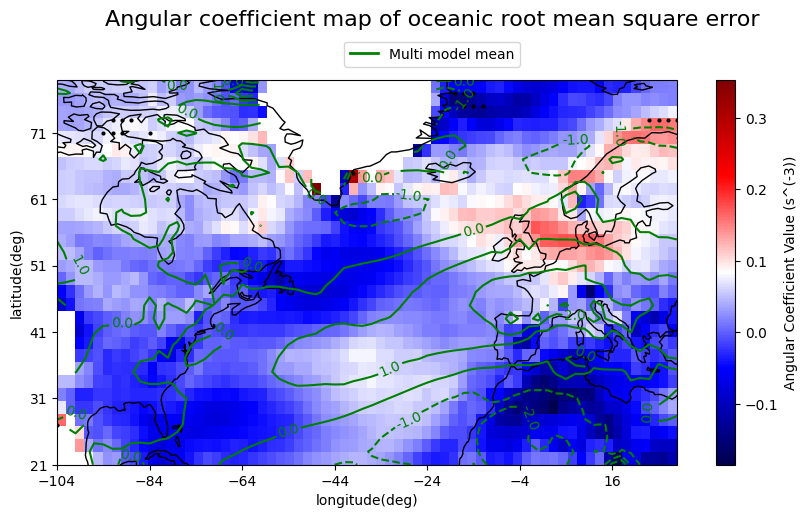

In [37]:
plot_m_reshape(models_atmos['ACCESS-CM2']['atmos North Atlantic bias DJF'],result_ocean_rmse[1],result_ocean_rmse[6],bias_multi_model_mean,'Angular coefficient map of oceanic root mean square error','(s^(-3))')

- Plotta il contorno del bias della multi model mean per ogni plot
- Metti risoluzione corretta da ipcc
- Aggiungi p-value e puntini dove c'è significatività statistica
- R^2 (quanta varianza non spiegata resta) --> ad es. risoluzione atmosferica e oceanica e vedere qual è R^2 per vedere cosa spiega
- Ridurre il box fino a -105°
- Orografia: max dell'orogrofia sul Nord America (box sopra le Montagne Rocciose) --> file orog per ogni modello, prendo un box sulle Rocky Mount. e prendere il max

Per p-value e R^2 prova ad usare scipy.stats.linregress:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html